In [1]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
import gymnasium as gym
import matplotlib.pyplot as plt
import class_setting
import util
import replay_buffer as rb

In [2]:
env_name = 'Pendulum-v1'
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_bound = env.action_space.high[0]

In [11]:
actor_lr = 3e-4
critric_lr = 3e-3
alpha_lr = 3e-4
num_episodes = 100
hidden_dim = 128
gamma = 0.99
tau = 0.005
buffer_size = 100000
minimal_size = 64
batch_size = 64
target_entropy = -env.action_space.shape[0]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
epi_list = np.empty((5, num_episodes))
for i in range(5):
    p_replay_buffer = rb.ReplayBuffer(state_dim, action_dim, buffer_size, device)
    pendulum_agent = class_setting.SACContinuous(p_replay_buffer, state_dim, hidden_dim, action_dim, 2, action_bound,
                                    actor_lr, critric_lr, alpha_lr, target_entropy, tau, gamma, device)

    return_list = util.train_off_policy_agent(env, pendulum_agent, num_episodes, minimal_size, batch_size)
    epi_list[i, :] = return_list

Iteration 9: 100%|██████████| 10/10 [00:16<00:00,  1.67s/it, episode=100, return=-363.807]


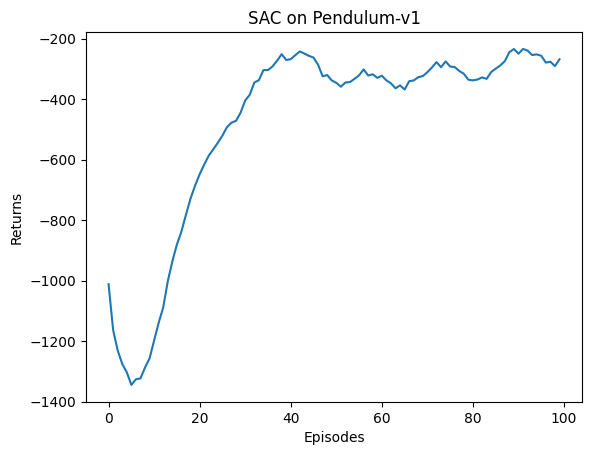

In [19]:
mean_list = np.mean(epi_list, axis=0)
smooth_return = util.smooth_figure(mean_list, 9)
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, smooth_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('SAC on {}'.format(env_name))
plt.show()

In [13]:
np.save('SAC.npy', epi_list)

# prioritized experience replay SAC

In [12]:
epi_list_per = np.empty((5, num_episodes))
for i in range(5):
    replay_buffer = rb.PrioritizedReplayBuffer(state_dim, action_dim, buffer_size, device)
    agent = class_setting.SACContinuous(replay_buffer, state_dim, hidden_dim, action_dim, 2, action_bound,
                                    actor_lr, critric_lr, alpha_lr, target_entropy, tau, gamma, device)
    return_list_PER = util.train_off_policy_agent(env, agent, num_episodes, minimal_size, batch_size)
    epi_list_per[i, :] = return_list_PER

Iteration 9: 100%|██████████| 10/10 [00:23<00:00,  2.31s/it, episode=100, return=-306.478]


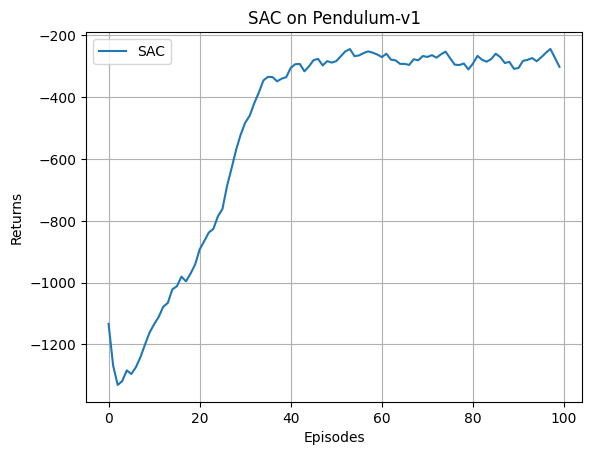

In [14]:
mean_per = epi_list_per.mean(axis=0)
smooth_return_per = util.smooth_figure(mean_per, 9)
episodes_list = list(range(len(return_list_PER)))
plt.plot(episodes_list, smooth_return)
plt.plot(episodes_list, smooth_return_per)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.legend(['SAC', 'SAC_PER'])
plt.title('SAC on {}'.format(env_name))
plt.grid()
plt.show()

In [18]:
np.save('SAC_PER.npy', epi_list_per)

# SAC-GAIL